$ \theta = \{\psi, \sigma \} $

$\psi$: Parametros para definição do modelo que será utilizado em cada estado<br>
$\sigma$: Parametros para cada Modelo $\{\sigma_1, \sigma_2, ...\}$ <br>

$ \beta: S \mapsto [0,1]^k \;\; onde \;\; k = |\sigma|$ <br>
$ \beta(s; \psi)_i = p_{\psi}(\sigma_i | s) \; \forall \; i \in (1, 2, ..., k)$ <br>
A função $ \beta $ define a probabilidade de cada parametro em $ \sigma $ ser o modelo utilizado pra gerar a transição em um estado <br>

$\mu: S \times S \times A \times \sigma \mapsto [0,1] $ <br>
$\mu(s', s, a, \sigma_x)= p_{\sigma_x}(s'|s,a)$ <br>
A função $ \mu $ define a probabilidade de transição para um estado, dado um par de estado e ação, seguindo o modelo $\sigma_x$ <br>

In [92]:
import numpy as np
import random

force = .5
actions = np.array([(force,0), (-force,0), (0,force), (0,-force)])
theta = [5, (.005,.3)]

def mu(s, a, p=2):
    acts = actions[a]
    return s + acts + np.random.normal(0, p, 2)

def beta(x,y):
    psi, _ = theta
    return 1*((x**2 + y**2)**(1/2) < psi)

def generate(s0, n):   
    _, sigma = theta
    s = s0
    for _ in range(n):
        a = np.random.choice(4, 1)[0]
        m = beta(s[:,0], s[:,1])[0]
        sa = np.insert(s, s.size, a)
        yield np.insert(sa, sa.size, m)
        # yield sa
        s = mu(s, a, sigma[m])

# def trajectory(s_0=(1,1), n=100):
#     gen = generate(s_0, n)
#     return np.fromiter(gen, dtype=np.dtype((float, 4)))

# s_0 = np.array([[0,0]])
# n = 1000

# O = trajectory(s_0, n)
# O[:] # all
# O[:,0:2] # states
# O[:,2] # actions
# O[:,3] # hidden models

In [93]:
import pandas as pd

def generate_data(trajectory_size=1000, n_trajectories=10, s_0=(0,0)):
    s_0 = np.array([s_0])
    gen = generate(s_0, 1)
    sx,sy,a,m = next(gen)
    df = pd.DataFrame({
        'n':[0],
        't':[0],
        's':[(sx,sy)],
        'a':[int(a)],
        'm':[int(m)]
        })

    for i in range(n_trajectories):
        gen = generate(s_0, trajectory_size)
        # for t,(sx,sy,a) in enumerate(gen):
        for t,(sx,sy,a,m) in enumerate(gen):
            df.loc[len(df.index)] = [int(i),int(t),(sx,sy),int(a),int(m)]
            # df.loc[len(df.index)] = [int(i),int(t),(sx,sy),int(a)]

    df.drop(0, inplace=True)
    return df

df = generate_data() 
df.head()

,n,t,s,a,m
1,0,0,"(0, 0)",0,1
2,0,1,"(0.34212326929378584, 0.05028161974656861)",2,1
3,0,2,"(0.01861080347742261, 0.45082811103804377)",2,1
4,0,3,"(-0.30186574230833146, 0.9217408773478398)",1,1
5,0,4,"(-0.14236165762369068, 0.6454140813549184)",2,1


<AxesSubplot: >

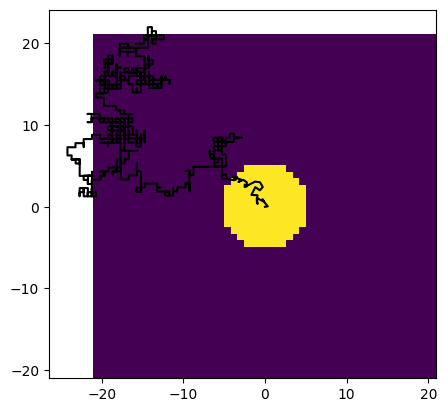

In [94]:
import matplotlib.pyplot as plt

def plot_trajectory(data, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    # ax.invert_yaxis()

    size = 20
    res = 50
    x = np.linspace(-size, size, res).reshape(-1,1)
    y = np.linspace(-size, size, res).reshape(-1,1)

    X,Y = np.meshgrid(x,y)
    ax.imshow(beta(X,Y), extent=(int(min(x))-1, int(max(x))+1, int(max(y))+1, int(min(y))-1))
    ax.invert_yaxis()

    df_s = pd.DataFrame(data.s.to_list(), columns=['x','y'])
    ax.plot(df_s.x, df_s.y, color='black')
    return ax

plot_trajectory(df[df.n==0])

In [111]:
import torch
from torch.autograd import Variable
from torch.distributions import normal
import torch.nn as nn
import torch.nn.functional as f

class BetaModel(nn.Module):
    def __init__(self):
        super(BetaModel, self).__init__()
        n_features = 2
        n_models = 2
        n_hidden = 10

        self.model = nn.Sequential(
            nn.Linear(n_features, n_hidden).double(),
            nn.ReLU(),
            # nn.Linear(n_hidden, n_hidden).double(),
            # nn.ReLU(),
            nn.Linear(n_hidden, n_models).double(),
            nn.ReLU(),
            nn.Softmax(dim=1)
            # nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        return self.model(x)

In [112]:
def loglike(beta, data):
    def prob(sig):
        acts = np.stack((
            np.take(actions[:,0], data.a.iloc[:-1]), 
            np.take(actions[:,1], data.a.iloc[:-1])
        ), axis=-1)

        s = Variable(torch.from_numpy(data['s'].iloc[:-1].apply(pd.Series).to_numpy())).type(torch.DoubleTensor)
        a = Variable(torch.from_numpy(acts)).type(torch.DoubleTensor)
        s_ = Variable(torch.from_numpy(data['s'].iloc[1:].apply(pd.Series).to_numpy())).type(torch.DoubleTensor)
        
        return torch.exp(normal.Normal(s[:,0] + a[:,0], sig).log_prob(s_[:,0])) * torch.exp(normal.Normal(s[:,1] + a[:,1], sig).log_prob(s_[:,1]))
    
    mi = torch.stack([prob(sig) for sig in theta[1]], dim=1)
    p_theta = torch.sum((mi * beta), 1) 

    # epsilon = len(theta[1]) * np.log(data.size)
    epsilon = 0
    temp = torch.log(p_theta)
    return -torch.sum(temp[~temp.isinf()]) + epsilon


# df_teste = df.iloc[:-1].copy()
# df_teste['m2'] = 1-df_teste.m
# loglike(df_teste[['m2', 'm']].to_numpy(), df)

tensor(-65717.0829, dtype=torch.float64)

In [114]:

def train(model, data, epochs=1000):
    x_train_tensor = torch.tensor(data.s.iloc[:-1].to_list()).type(torch.DoubleTensor)
    
    optim = torch.optim.SGD(model.parameters(), lr=1e-2)#, momentum=0.9)
    # loss = nn.MSELoss(reduction='mean')
    # loss = nn.CrossEntropyLoss()
    # loss = nn.NLLLoss()
    loss = loglike

    model.train(True)
    for _ in range(epochs):
        outputs = model(x_train_tensor)
        ll = loss(outputs, data)
        
        if ll.data == torch.inf or torch.isnan(ll.data):
            break
        ll.backward()
        optim.step() 
        optim.zero_grad()
    model.train(False)

    return ll



# def train_models(data, n_models=3):
#     models = [BetaModel() for _ in range(n_models)]
#     results = [train(model, data) for model in models]
#     return models, results
# mod, res = train_models(df[df.n==0], 1)
# res

[tensor(-6874.9862, dtype=torch.float64, grad_fn=<AddBackward0>)]

In [87]:
def train_models(data, n_models=10):
    models = [BetaModel() for _ in range(n_models)]
    results = [train(model, data) for model in models]
    return models, results

n = 10 
m = 5
models = []
results = []
for i in range(n):
    mod, res = train_models(df[df.n==i], m)
    models.append(mod)
    results.append(res)

<AxesSubplot: >

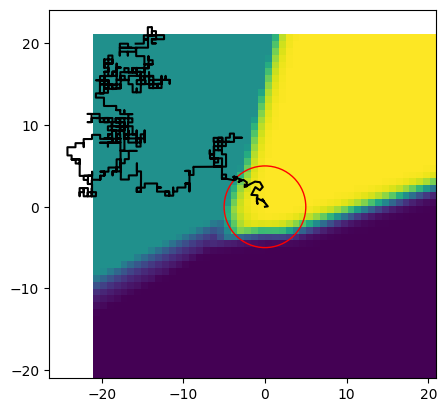

In [116]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_test(model, data, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    size = 20
    res = 50
    x = np.linspace(-size, size, res).reshape(-1,1)
    y = np.linspace(-size, size, res).reshape(-1,1)

    X,Y = np.meshgrid(x,y)

    with torch.no_grad():
        d = np.stack((X, Y), axis=-1).reshape(-1, 2)
        d = torch.from_numpy(d).type(torch.DoubleTensor)
        corr = model(d)[:,1].reshape(int(X.size**(1/2)), int(X.size**(1/2)))
        # ax.imshow(corr, extent=(-r, r, r, -r), vmin=0, vmax=1)
        ax.imshow(corr, extent=(int(min(x))-1, int(max(x))+1, int(max(y))+1, int(min(y))-1))
    ax.invert_yaxis()

    df_s = pd.DataFrame(data.s.to_list(), columns=['x','y'])
    ax.plot(df_s.x, df_s.y, color='black')
    ax.add_patch(Circle((0, 0), theta[0], edgecolor='red', fill=False))

    return ax


i = 0
j = 0
plot_test(models[i][j], df[df.n==i])

In [119]:
df_teste = df.iloc[:-1].copy()
df_teste['m2'] = 1-df_teste.m

df_results = pd.DataFrame({
    "n": [i for i,values in enumerate(results) for v in values],
    "nn": [j for i,values in enumerate(results) for j,v in enumerate(values)],
    "ll": [v.item() for values in results for v in values],
    "ll_ideal": [loglike(np.stack(
            (1-df.iloc[:-1].m, df.iloc[:-1].m), 
            axis=-1
        ), df).item() for i,values in enumerate(results) for j,v in enumerate(values)],
})

df_results.head(10)

,n,nn,ll,ll_ideal
0,0,0,-6874.986217,-65717.082874


In [123]:
df_results[['n', 'll']].groupby('n').agg(['mean', 'std', 'min', 'max'])

ll                              
          mean std          min          max
n                                           
0 -6874.986217 NaN -6874.986217 -6874.986217

In [124]:
df_results[df_results.n==0]

,n,nn,ll,ll_ideal
0,0,0,-6874.986217,-65717.082874


<AxesSubplot: >

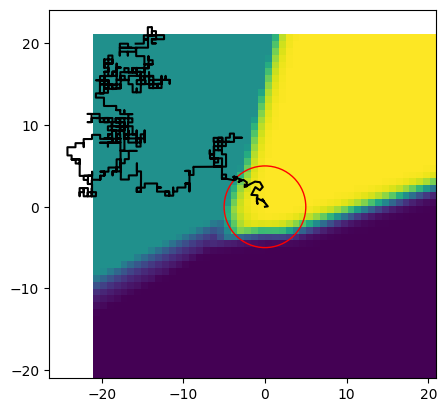

In [125]:
i,j = 0,0
plot_test(models[i][j], df[df.n==i])